#### Import the required libraries and initial view

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/sujith/trainData/driving_log.csv', header=None)

In [3]:
df.columns=["centre", "left", "right", "steer", "x1", "x2", "x3"]

In [4]:
df.head()

,centre,left,right,steer,x1,x2,x3
0,/Users/sujith/trainData/IMG/center_2019_02_15_...,/Users/sujith/trainData/IMG/left_2019_02_15_12...,/Users/sujith/trainData/IMG/right_2019_02_15_1...,0.00,1.0,0,16.22692
1,/Users/sujith/trainData/IMG/center_2019_02_15_...,/Users/sujith/trainData/IMG/left_2019_02_15_12...,/Users/sujith/trainData/IMG/right_2019_02_15_1...,-0.15,1.0,0,17.51071
2,/Users/sujith/trainData/IMG/center_2019_02_15_...,/Users/sujith/trainData/IMG/left_2019_02_15_12...,/Users/sujith/trainData/IMG/right_2019_02_15_1...,-0.40,1.0,0,18.65486
3,/Users/sujith/trainData/IMG/center_2019_02_15_...,/Users/sujith/trainData/IMG/left_2019_02_15_12...,/Users/sujith/trainData/IMG/right_2019_02_15_1...,0.00,1.0,0,19.84270
4,/Users/sujith/trainData/IMG/center_2019_02_15_...,/Users/sujith/trainData/IMG/left_2019_02_15_12...,/Users/sujith/trainData/IMG/right_2019_02_15_1...,0.00,1.0,0,21.03341


In [5]:
df.shape

(3466, 7)

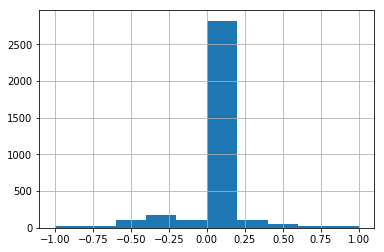

In [6]:
df.steer.hist()
plt.show()

#### Verify that IMG folder and the CSV file are in sync

In [7]:
newdf = pd.read_csv('/Users/sujith/trainData/driving_log.csv', header=None)
orig_count = len(newdf)
print("Received DF with rows = ", orig_count)

for i in range(orig_count):
    for j in range(3):
        path = newdf.iloc[i][j]
        if not os.path.exists(path):
            print(" *************   Not found: ", path)

print ("Done...")

Received DF with rows =  3466
Done...


#### Dropping the near-zero predictions

This function takes in the range of steering angle (either side of 0-degree) and the proportion of the images to be deleted as parms. It identifies all the images with steering angle less than the provided range, calculate the count of images to be deleted (based on parm provided) and randomly deletes the portion of images.

**Note:** Apart from removing the entries from the CSV file, I am also deleting the images from the IMG folder so that I could save on both time and bandwidth when uploading the images to Udacity platform for training.

In [8]:
def drop_zero_steering(dataframe, drop_zero_prob=0.75, drop_range=0.05):
    orig_count = len(dataframe)
    print("Received DF with rows = ", orig_count)
    near_zero_idx = np.where(abs(pd.to_numeric(dataframe['steer'])) < drop_range)[0]
    print("Count of near_zero_idx: ", len(near_zero_idx))
    delete_count = int(drop_zero_prob * len(near_zero_idx))
    print("Count identified for deletion: ", delete_count)
    delete_indices = np.random.choice(near_zero_idx, delete_count, replace=False)
    print("Count of identified indices for deletion: ", len(delete_indices))
    for i in range(delete_count):
        for j in range(3):
            path = dataframe.iloc[delete_indices[i]][j]
            if os.path.exists(path):
                os.remove(path)
                # print(path)
            else:
                print(" *************   Not found: ", path)

    # Update steering angles array.
    dataframe.drop(dataframe.index[delete_indices], inplace=True)

    new_count = len(dataframe)
    print("{} rows dropped.".format(orig_count - new_count))
    print("Output DF has rows = ", new_count)
    return dataframe

In [9]:
temp = drop_zero_steering(df)
temp.to_csv("/Users/sujith/trainData/driving_log_norm.csv", index=None, header=False)


Received DF with rows =  3466
Count of near_zero_idx:  2721
Count identified for deletion:  2040
Count of identified indices for deletion:  2040
2040 rows dropped.
Output DF has rows =  1426


#### Verify that IMG folder and the CSV file are in sync (after deletion)

In [10]:
newdf = pd.read_csv('/Users/sujith/trainData/driving_log_norm.csv', header=None)
orig_count = len(newdf)
print("Received DF with rows = ", orig_count)

for i in range(orig_count):
    for j in range(3):
        path = newdf.iloc[i][j]
        if not os.path.exists(path):
            print(" *************   Not found: ", path)

print ("Done...")

Received DF with rows =  1426
Done...


#### Visualize the effect of removal

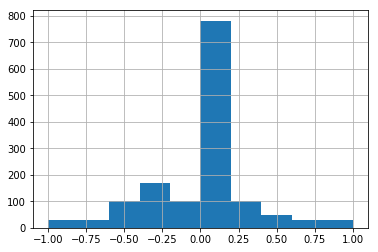

In [11]:
temp.steer.hist()
plt.show()

## Ignore below steps.
There are two steps which are actually performed in the model pipeline. They are:
1. Adjusting the steering angle for left and right camera images
2. Data augmentation by horizontal flip of images. 

As these are part of pipeline, it is not performed locally, but I am running the below CELLs just to capture the effect of these steps in a histogram.

In [12]:
def correct_steer(temp):
    measurements = []
    correction = 0.2

    for row in range(len(temp)):
        for i in range(3):
            if i == 0:
                measurements.append(float(temp.iloc[row,3]))
            elif i == 1: # left camera
                measurements.append(float(temp.iloc[row,3]) + correction)
            else:        # right camera
                measurements.append(float(temp.iloc[row,3]) - correction)
    return measurements


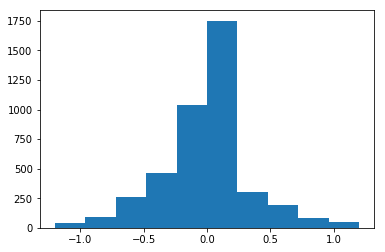

In [13]:
m = correct_steer(temp)
plt.hist(m)
plt.show()

In [14]:
def aug_imgs(measurements):
    aug_measus = []
    for measu in measurements:
        aug_measus.append(measu)
        aug_measus.append(-1.0 * measu)
    return aug_measus


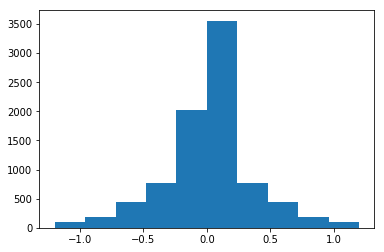

In [15]:
a = aug_imgs(m)
plt.hist(a)
plt.show()